In [1]:
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from PIL import Image
import io
import json
import time

In [2]:
# https://huggingface.co/datasets/huggan/wikiart/tree/main/data
parquets = [
    "./data/train-00000-of-00072.parquet",
    "./data/train-00001-of-00072.parquet",
    "./data/train-00002-of-00072.parquet",
]

df_dataset = pd.DataFrame([])
for p in parquets:
    df_dataset = pd.concat([df_dataset, pq.read_table(p).to_pandas()], ignore_index=True)
df_dataset

,image,artist,genre,style
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,4,21
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,7,4
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,16,6,20
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17,2,12
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,9,10,23
...,...,...,...,...
3391,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,11,6,21
3392,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,3,23
3393,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,8,4
3394,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,8,20


In [3]:
with open("./data/dataset_infos.json", 'r') as file:
    dataset_info = json.load(file)

artists = dataset_info["huggan--wikiart"]["features"]["artist"]["names"]
genres = dataset_info["huggan--wikiart"]["features"]["genre"]["names"]
styles = dataset_info["huggan--wikiart"]["features"]["style"]["names"]

vincent-van-gogh landscape Realism


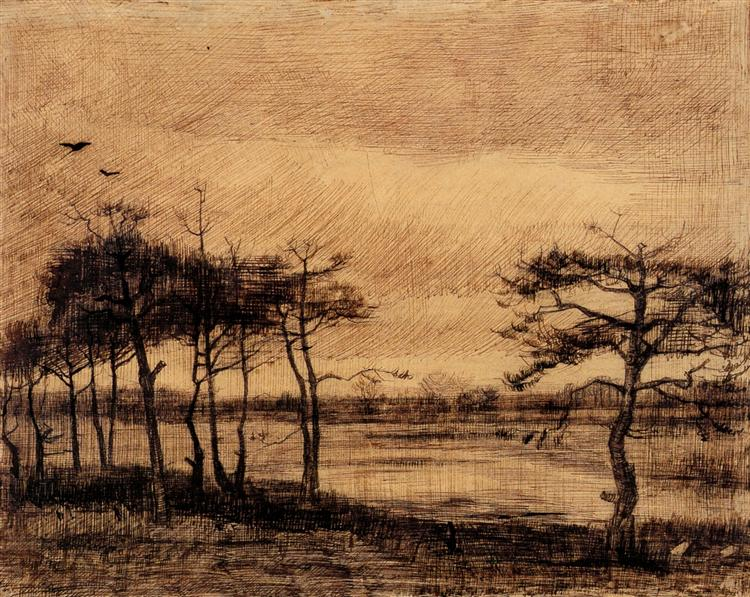

In [4]:
image = Image.open(io.BytesIO(df_dataset.image[0]["bytes"]))
print(artists[df_dataset["artist"][0]], genres[df_dataset["genre"][0]], styles[df_dataset["style"][0]])
image

In [5]:
dataset_artist_values = pd.DataFrame(df_dataset["artist"].value_counts()).reset_index().reset_index(names="new_artist_label")
dataset_artist_values['artist_name'] = dataset_artist_values["artist"].apply(lambda x: artists[x])
dataset_artist_values

,new_artist_label,artist,count,artist_name
0,0,22,339,vincent-van-gogh
1,1,14,328,nicholas-roerich
2,2,17,249,pierre-auguste-renoir
3,3,4,220,claude-monet
4,4,18,179,pyotr-konchalovsky
5,5,2,145,camille-pissarro
6,6,11,135,john-singer-sargent
7,7,15,134,pablo-picasso
8,8,1,133,boris-kustodiev
9,9,25,133,albrecht-durer


In [6]:
dataset_genres_values = pd.DataFrame(df_dataset["genre"].value_counts()).reset_index().reset_index(names="new_genre_label")
dataset_genres_values['genre_name'] = dataset_genres_values["genre"].apply(lambda x: genres[x])
dataset_genres_values

,new_genre_label,genre,count,genre_name
0,0,4,784,landscape
1,1,6,515,portrait
2,2,10,495,Unknown Genre
3,3,2,462,genre_painting
4,4,8,339,sketch_and_study
5,5,1,233,cityscape
6,6,7,213,religious_painting
7,7,3,149,illustration
8,8,9,120,still_life
9,9,5,85,nude_painting


In [7]:
dataset_style_values = pd.DataFrame(df_dataset["style"].value_counts()).reset_index().reset_index(names="new_style_label")
dataset_style_values['style_name'] = dataset_style_values["style"].apply(lambda x: styles[x])
dataset_style_values

,new_style_label,style,count,style_name
0,0,12,971,Impressionism
1,1,21,672,Realism
2,2,20,348,Post_Impressionism
3,3,23,245,Romanticism
4,4,24,243,Symbolism
5,5,3,241,Art_Nouveau
6,6,17,151,Northern_Renaissance
7,7,9,143,Expressionism
8,8,4,133,Baroque
9,9,15,126,Naive_Art_Primitivism


In [8]:
df_dataset_labeled = pd.merge(df_dataset, dataset_artist_values[["artist", "new_artist_label"]], on="artist", how="left")
df_dataset_labeled = pd.merge(df_dataset_labeled, dataset_genres_values[["genre", "new_genre_label"]], on="genre", how="left")
df_dataset_labeled = pd.merge(df_dataset_labeled, dataset_style_values[["style", "new_style_label"]], on="style", how="left")
df_dataset_labeled

,image,artist,genre,style,new_artist_label,new_genre_label,new_style_label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,4,21,0,0,1
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,7,4,11,6,8
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,16,6,20,14,1,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17,2,12,2,3,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,9,10,23,19,2,3
...,...,...,...,...,...,...,...
3391,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,11,6,21,6,1,1
3392,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,3,23,10,7,3
3393,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,8,4,11,4,8
3394,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,8,20,0,4,2


In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, df_dataset, target_name, transform=None, target_transform=None):
        self.img_labels = df_dataset[target_name]
        self.img_bytes = df_dataset["image"]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = Image.open(io.BytesIO(self.img_bytes[idx]["bytes"]))
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
data_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

train_dataset = CustomImageDataset(df_dataset=df_dataset_labeled, target_name="new_artist_label", transform=data_transforms)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Feature batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])
Label: 14


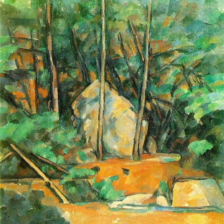

In [12]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
img = transforms.ToPILImage()(img)
print(f"Label: {label}")
img


In [13]:
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
np.arange(len(df_dataset_labeled["new_artist_label"])),
test_size=0.2,
shuffle=True,
stratify=None)

In [14]:
train_idx, valid_idx

(array([2808,  715, 3085, ...,  114,  100, 2276], shape=(2716,)),
 array([ 904, 1637, 1696, 1944, 2699, 2765, 2373,  731,  473, 1625, 2483,
        1321,  684, 2614, 1711,   59,  912, 2667, 1832, 2729, 1130,  345,
        1498,  810, 1612, 3069,  500, 2244, 2075,  678,   50, 1354, 1105,
         759, 1131,  817, 1188,  298, 1416, 1024, 2477, 2966,  541, 1072,
        1700, 2129, 2690, 1323, 2913, 2243, 1860,  757, 1356, 2091,  806,
         445, 2413, 3186, 2048, 2530, 2777, 1496, 2812,  803, 2639,   44,
        2390, 2423, 2709,  204, 1140, 1291, 2984, 1533, 1794, 1571,  969,
        2445, 1386, 1968, 2728, 1579, 1284, 3040, 3149, 3239, 1107, 3270,
        2919,  779, 1929, 3019, 2479,  700,  880, 2090, 1021,  551, 1303,
        3024,   60, 2899,  105, 2902, 1244, 1005, 1983,   25, 1760,  256,
         118, 1033, 3276, 2764, 1385, 3255,  829, 1100,  639, 3321, 1565,
         375, 3297, 1293, 2661, 1620, 1359,  495,  156, 1960, 1791, 3037,
         491,  240, 3360, 1801,  135, 2761, 28

In [15]:
df_dataset_labeled["new_artist_label"].value_counts()

new_artist_label
0     339
1     328
2     249
3     220
4     179
5     145
6     135
7     134
8     133
9     133
10    133
11    133
12    132
13    112
14    112
15    107
16    103
17    100
18    100
19     93
20     90
21     85
22     83
23     18
Name: count, dtype: int64

In [16]:
df_dataset_labeled.iloc[train_idx, :]["new_artist_label"].value_counts()

new_artist_label
0     275
1     257
2     196
3     186
4     145
5     118
11    111
6     111
7     108
9     106
12    105
8     103
10     99
14     86
13     85
15     84
17     83
16     83
18     75
21     75
19     72
20     70
22     69
23     14
Name: count, dtype: int64

In [17]:
339 * 0.8, 339 * 0.2

(271.2, 67.8)

In [18]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

dataset = CustomImageDataset(df_dataset_labeled, target_name="new_artist_label", transform=data_transforms)
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Label: 5


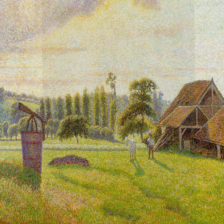

In [19]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
img = transforms.ToPILImage()(img)
print(f"Label: {label}")
img


In [20]:
train_labels.dtype

torch.int64

In [21]:
model = models.resnet18(pretrained=True)
device = torch.device("cpu")

# Freeze base layers
# for param in model.parameters():
#     param.requires_grad = False

# Replace classifier layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(dataset_artist_values))  # For your number of classes
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloaders = {
    'train': train_loader,
    'val': valid_loader
}

dataset_lens = {
    'train': len(train_idx),
    'val': len(valid_idx)
}


/Users/adan.mora/Desktop/code/university/deep-learning-and-big-data-course/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adan.mora/Desktop/code/university/deep-learning-and-big-data-course/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def train_model(model, criterion, optimizer, num_epochs=3):
    since = time.time()
    for epoch in range(num_epochs):
        print(f"\n\n-------\nEpoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_lens[phase]
            epoch_acc = running_corrects.double() / dataset_lens[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    print(f"Training complete in {(time.time() - since):.0f}s")

In [23]:
num_epochs = 10
train_model(model, criterion, optimizer, num_epochs=num_epochs)



-------
Epoch 1/10
train Loss: 2.2041 Acc: 0.3785
val Loss: 2.3973 Acc: 0.3544


-------
Epoch 2/10
train Loss: 1.5932 Acc: 0.5376
val Loss: 2.2265 Acc: 0.4309


-------
Epoch 3/10


KeyboardInterrupt: 

In [26]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(dataset_artist_values))  # For your number of classes
model = model.to(device)

model.load_state_dict(torch.load("./data/resnet18_artwiki_model_state.pth", weights_only=True, map_location=torch.device('cpu')))

model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def predict(model, image_path, device='cpu', input_size=(224, 224)):
    """
    Predict the class of an image using the given PyTorch model.

    Args:
        model: The trained PyTorch model.
        image_path: Path to the image file.
        device: Device to run the model on ('cpu' or 'cuda').
        input_size: Tuple specifying the target size for the image (default is (224, 224)).

    Returns:
        The predicted class or probabilities.
    """
    # Define the preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    
    # Move the model and image to the specified device
    model = model.to(device)
    image = image.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    return probabilities, outputs

In [49]:
probabilities, outputs = predict(model, "./data/beach-monet.png")
predicted_class = torch.argmax(probabilities).item()
print(f"Predicted class probability: {torch.max(probabilities) * 100}")
dataset_artist_values[dataset_artist_values["new_artist_label"] == predicted_class].head(1)


Predicted class probability: 94.26097106933594


,new_artist_label,artist,count,artist_name
3,3,4,220,claude-monet


In [50]:
values, indices = torch.topk(probabilities, k=5)

print(f"Top 5 predicted classes probabilities:")
for p in list(zip(values.numpy().tolist(), indices.numpy().tolist())):
    print(f"{p[0] * 100:.2f}% - {dataset_artist_values[dataset_artist_values['new_artist_label'] == p[1]].head(1).artist_name.values[0]}")

Top 5 predicted classes probabilities:
94.26% - claude-monet
1.37% - eugene-boudin
1.11% - camille-pissarro
0.74% - vincent-van-gogh
0.59% - salvador-dali


In [51]:
df_dataset_labeled

,image,artist,genre,style,new_artist_label,new_genre_label,new_style_label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,4,21,0,0,1
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,7,4,11,6,8
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,16,6,20,14,1,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17,2,12,2,3,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,9,10,23,19,2,3
...,...,...,...,...,...,...,...
3391,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,11,6,21,6,1,1
3392,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,3,23,10,7,3
3393,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,8,4,11,4,8
3394,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,8,20,0,4,2


# Multilabel

In [59]:
class MultiLabelResNet(torch.nn.Module):
    def __init__(self, backbone_model, num_features):
        super(MultiLabelResNet, self).__init__()
        self.backbone_model = backbone_model

        num_ftrs = self.backbone_model.fc.in_features
        self.backbone_model.fc = torch.nn.Identity()
        
        # Three independent classification heads
        self.head_artist = torch.nn.Linear(num_ftrs, num_features[0])
        self.head_genre = torch.nn.Linear(num_ftrs, num_features[1])
        self.head_style = torch.nn.Linear(num_ftrs, num_features[2])

    def forward(self, x):
        features = self.backbone_model(x)  # Get features from ResNet
        
        out1 = self.head_artist(features)
        out2 = self.head_genre(features)
        out3 = self.head_style(features)
        
        return out1, out2, out3

In [53]:
df_dataset_multilabeled = df_dataset_labeled.copy()
df_dataset_multilabeled['multilabels'] = df_dataset_labeled.apply(lambda row: [row['new_artist_label'], row['new_genre_label'], row['new_style_label']], axis=1)
df_dataset_multilabeled

,image,artist,genre,style,new_artist_label,new_genre_label,new_style_label,multilabels
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,4,21,0,0,1,"[0, 0, 1]"
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,7,4,11,6,8,"[11, 6, 8]"
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,16,6,20,14,1,2,"[14, 1, 2]"
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17,2,12,2,3,0,"[2, 3, 0]"
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,9,10,23,19,2,3,"[19, 2, 3]"
...,...,...,...,...,...,...,...,...
3391,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,11,6,21,6,1,1,"[6, 1, 1]"
3392,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,3,23,10,7,3,"[10, 7, 3]"
3393,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,20,8,4,11,4,8,"[11, 4, 8]"
3394,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,22,8,20,0,4,2,"[0, 4, 2]"


In [54]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

dataset = CustomImageDataset(df_dataset_multilabeled, target_name="multilabels", transform=data_transforms, 
                             target_transform=lambda x: torch.tensor(x, dtype=torch.int64))
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

dataloaders = {
    'train': train_loader,
    'val': valid_loader
}

dataset_lens = {
    'train': len(train_idx),
    'val': len(valid_idx)
}

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32, 3])
Label: tensor([6, 1, 1])


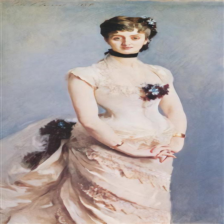

In [55]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
img = transforms.ToPILImage()(img)
print(f"Label: {label}")
img

In [56]:
train_labels

tensor([[ 6,  1,  1],
        [17,  0,  1],
        [ 3,  5,  0],
        [ 6,  0,  0],
        [20,  9,  5],
        [ 2,  0,  0],
        [ 3,  2,  0],
        [ 4,  8,  1],
        [ 5,  3,  0],
        [ 3,  2,  0],
        [12,  6,  9],
        [20,  3,  5],
        [14,  5,  3],
        [ 2,  2,  0],
        [11,  6,  8],
        [ 3,  0,  0],
        [16,  1,  1],
        [11,  2,  8],
        [ 1,  4,  4],
        [22,  0,  1],
        [ 0,  4,  2],
        [ 4,  0,  2],
        [ 9,  6,  6],
        [ 3,  3,  0],
        [ 0,  4,  2],
        [ 0,  1,  1],
        [12,  6,  9],
        [ 8,  1,  5],
        [ 2,  3,  0],
        [ 1,  0,  4],
        [ 1,  5,  4],
        [ 0,  3,  1]])

In [57]:
train_labels[:, 0]

tensor([ 6, 17,  3,  6, 20,  2,  3,  4,  5,  3, 12, 20, 14,  2, 11,  3, 16, 11,
         1, 22,  0,  4,  9,  3,  0,  0, 12,  8,  2,  1,  1,  0])

In [52]:
[len(dataset_artist_values), len(dataset_genres_values), len(dataset_style_values)]

[24, 11, 16]

In [60]:
resnet_model = models.resnet18(pretrained=True)
device = torch.device("cpu")

model = MultiLabelResNet(resnet_model, [len(dataset_artist_values), len(dataset_genres_values), len(dataset_style_values)])

# Freeze base layers
# for param in model.parameters():
#     param.requires_grad = False

model = model.to(device)

criterion_artists = torch.nn.CrossEntropyLoss()
criterion_genres = torch.nn.CrossEntropyLoss()
criterion_styles = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
def train_model(model, criterion_artists, criterion_genres, criterion_styles, optimizer, num_epochs=3):
    since = time.time()
    for epoch in range(num_epochs):
        print(f"\n\n-------\nEpoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss_artist = 0.0
            running_loss_genre = 0.0
            running_loss_style = 0.0
            running_corrects_artist = 0.0
            running_corrects_genre = 0.0
            running_corrects_style = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out_artist, out_genre, out_style = model(inputs)
                    loss_artist = criterion_artists(out_artist, labels[:, 0])
                    loss_genre = criterion_genres(out_genre, labels[:, 1])
                    loss_style = criterion_styles(out_style, labels[:, 2])
                    loss_total = loss_artist + loss_genre + loss_style

                    if phase == 'train':
                        (loss_total).backward()
                        optimizer.step()

                running_loss_artist += loss_artist.item() * inputs.size(0)
                running_corrects_artist += torch.sum(torch.argmax(out_artist, 1) == labels[:, 0].data)

                running_loss_genre += loss_genre.item() * inputs.size(0)
                running_corrects_genre += torch.sum(torch.argmax(out_genre, 1) == labels[:, 1].data)

                running_loss_style += loss_style.item() * inputs.size(0)
                running_corrects_style += torch.sum(torch.argmax(out_style, 1) == labels[:, 2].data)

            epoch_loss_artist = running_loss_artist / dataset_lens[phase]
            epoch_acc_artist = running_corrects_artist.double() / dataset_lens[phase]
            print(f"{phase} Artist Loss: {epoch_loss_artist:.4f} Acc: {epoch_acc_artist:.4f}")

            epoch_loss_genre = running_loss_genre / dataset_lens[phase]
            epoch_acc_genre = running_corrects_genre.double() / dataset_lens[phase]
            print(f"{phase} Genre Loss: {epoch_loss_genre:.4f} Acc: {epoch_acc_genre:.4f}")

            epoch_loss_style = running_loss_style / dataset_lens[phase]
            epoch_acc_style = running_corrects_style.double() / dataset_lens[phase]
            print(f"{phase} Style Loss: {epoch_loss_style:.4f} Acc: {epoch_acc_style:.4f}")

    print(f"Training complete in {(time.time() - since):.0f}s")

In [62]:
num_epochs = 10
train_model(model, criterion_artists, criterion_genres, criterion_styles, optimizer, num_epochs=num_epochs)



-------
Epoch 1/10
